In [17]:
import copy
import difflib
import pickle

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from cannibalisation.data_preparation import CannibalisationListingsData
from cannibalisation.depreciation_data import DepreciationData
from cannibalisation.utils.helpers import CbData, interpolate_missing_ages_price, get_intersection_points
from cannibalisation.utils.constants import USER_FEEDBACK_FILTER_QUERY, AVOID_COUNT_COLUMNS
from ds_helpers.RedisManager import RedisManager
from ds_helpers.helpers import get_formatted_columns, get_formatted_list, get_column_wise_data, listing_status_db_update
from dynamic_pricing_code.helpers import sql_result, add_log, config_data, write_in_sheet, read_sheet
from IPython.display import Image

In [18]:
# Global minima depreciation data
Image(filename='../../docs/cannibalisation/images/FIG 1 - global minima depr.jpg')

In [20]:
# Maxima appreciation data
Image(filename='../../docs/cannibalisation/images/FIG 2 - maxima appreciation.jpg')

In [22]:
# Minima appreciation data intersection with TD data
Image(filename='../../docs/cannibalisation/images/FIG 3 - minima appr_td intersection.jpg')

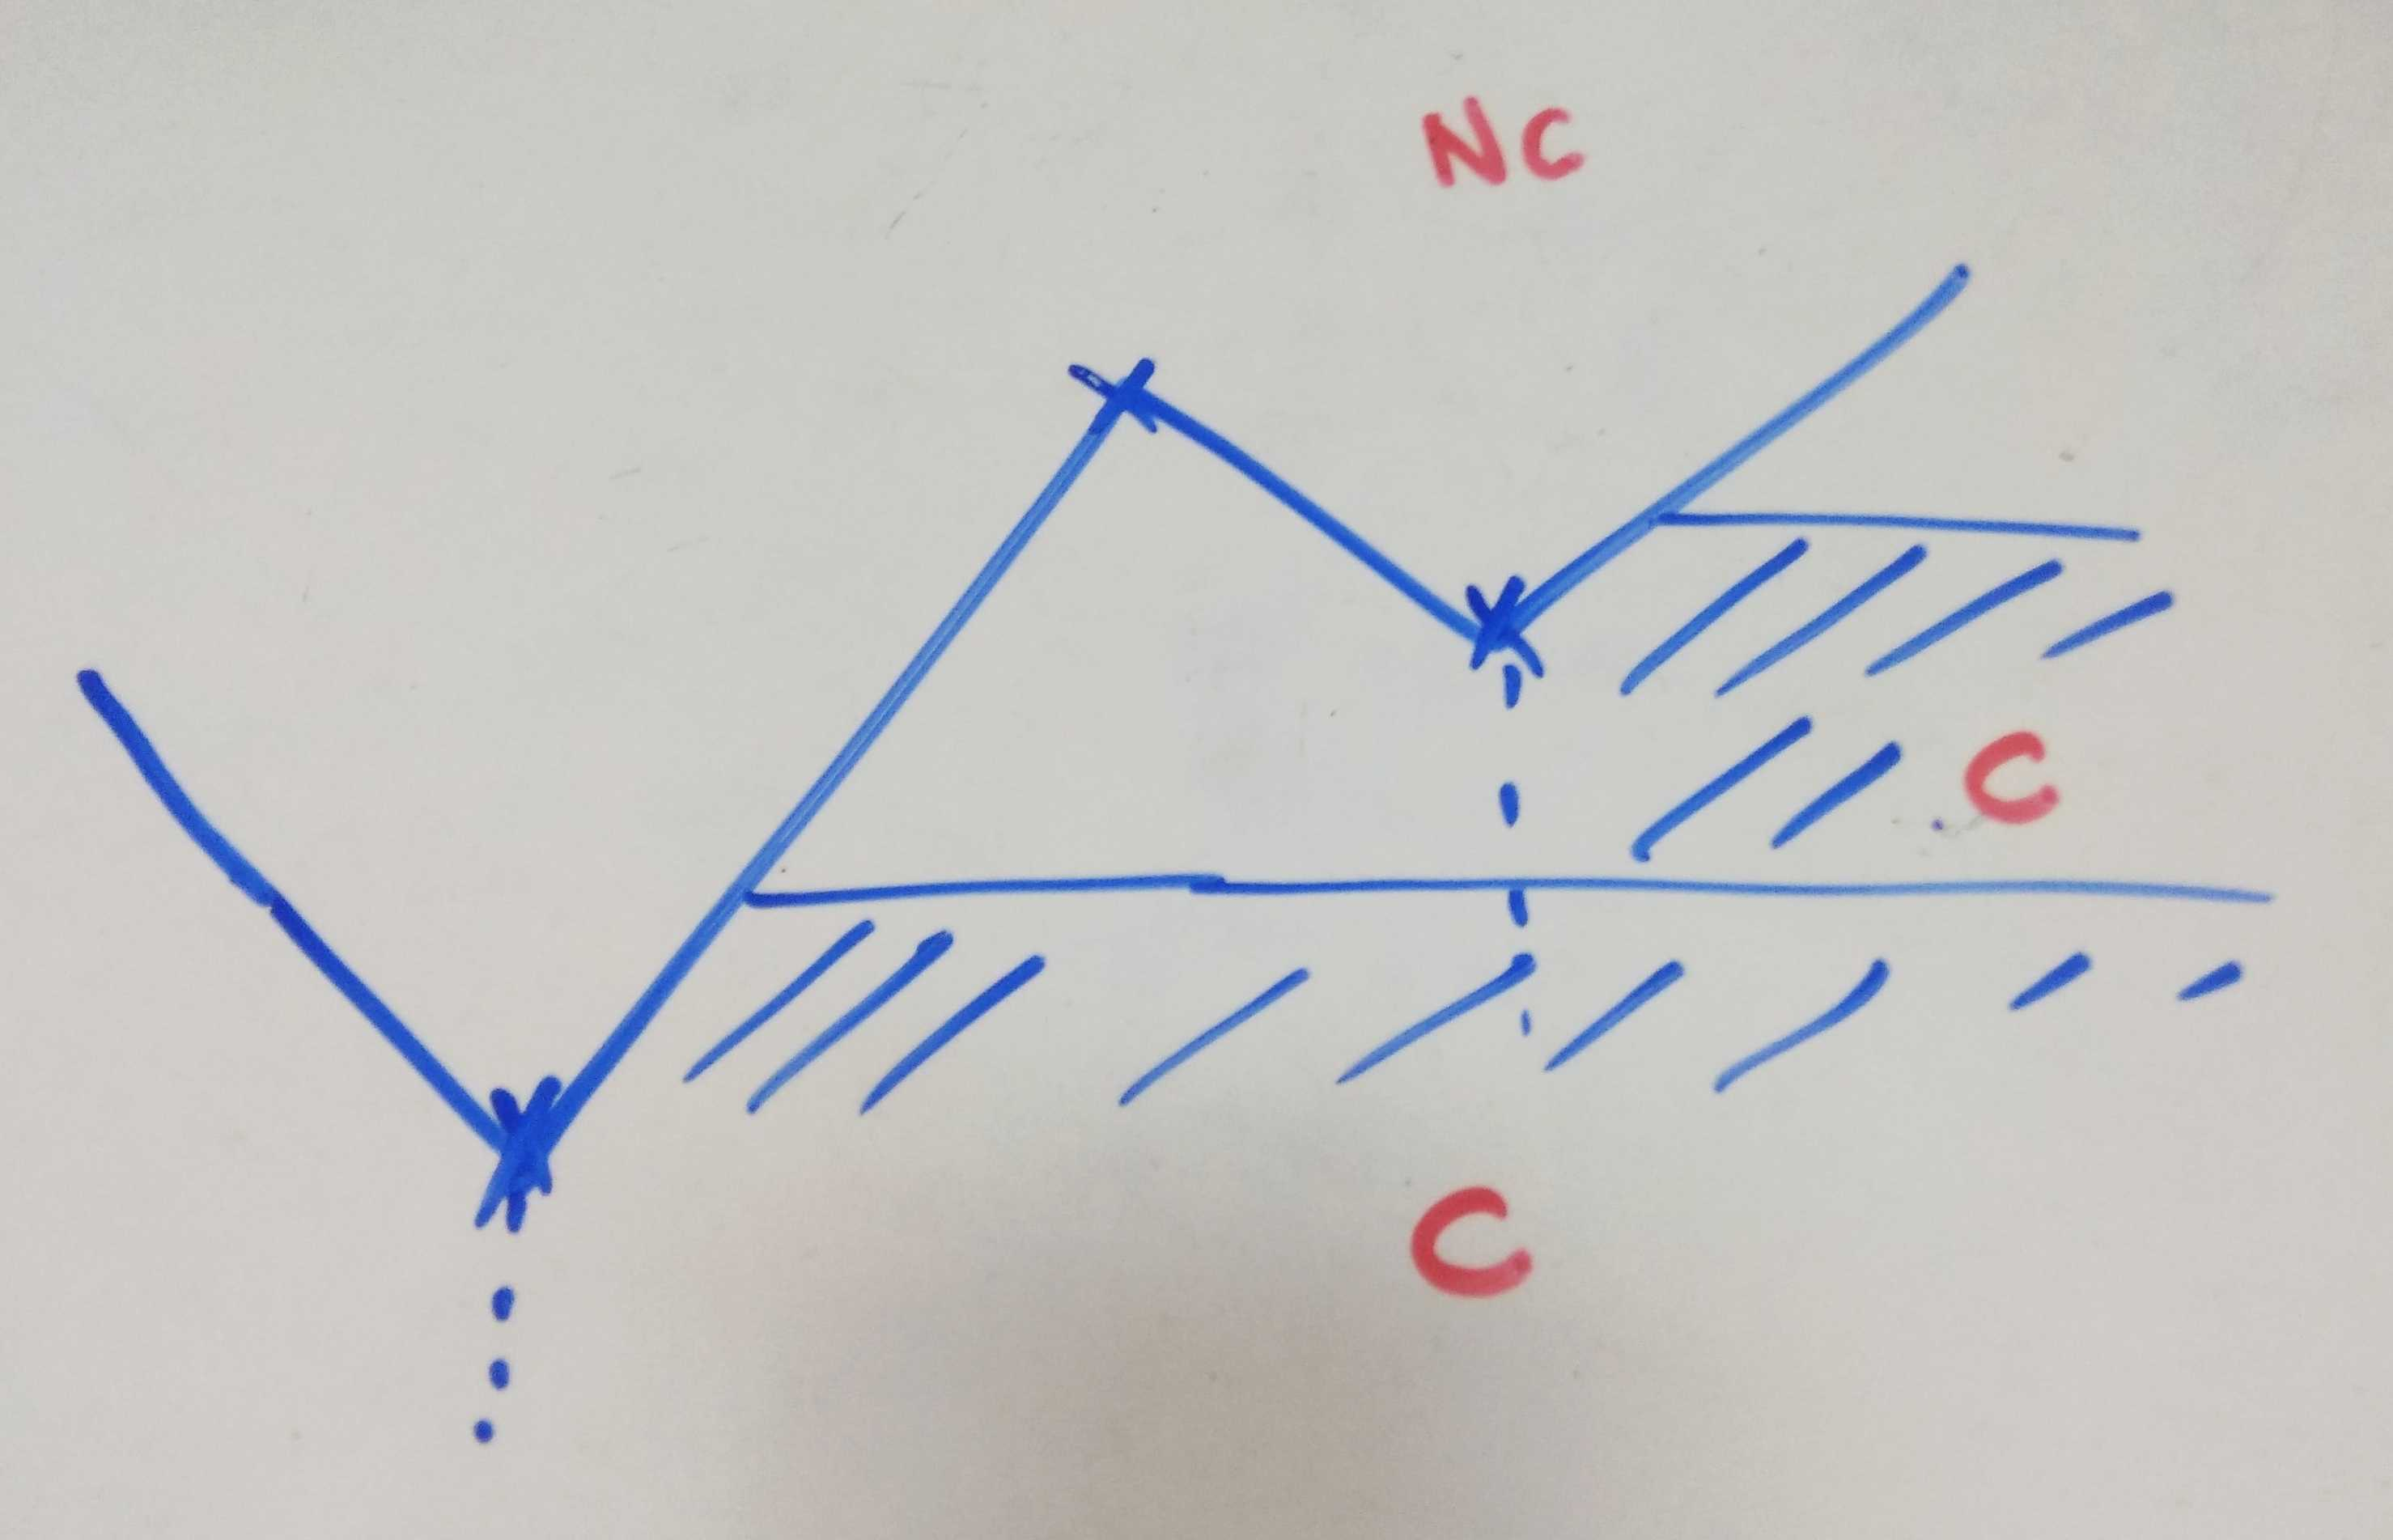

In [23]:
# Increasing minima appreciation data
Image(filename='../../docs/cannibalisation/images/FIG 4 - increasing minima appr.jpg')

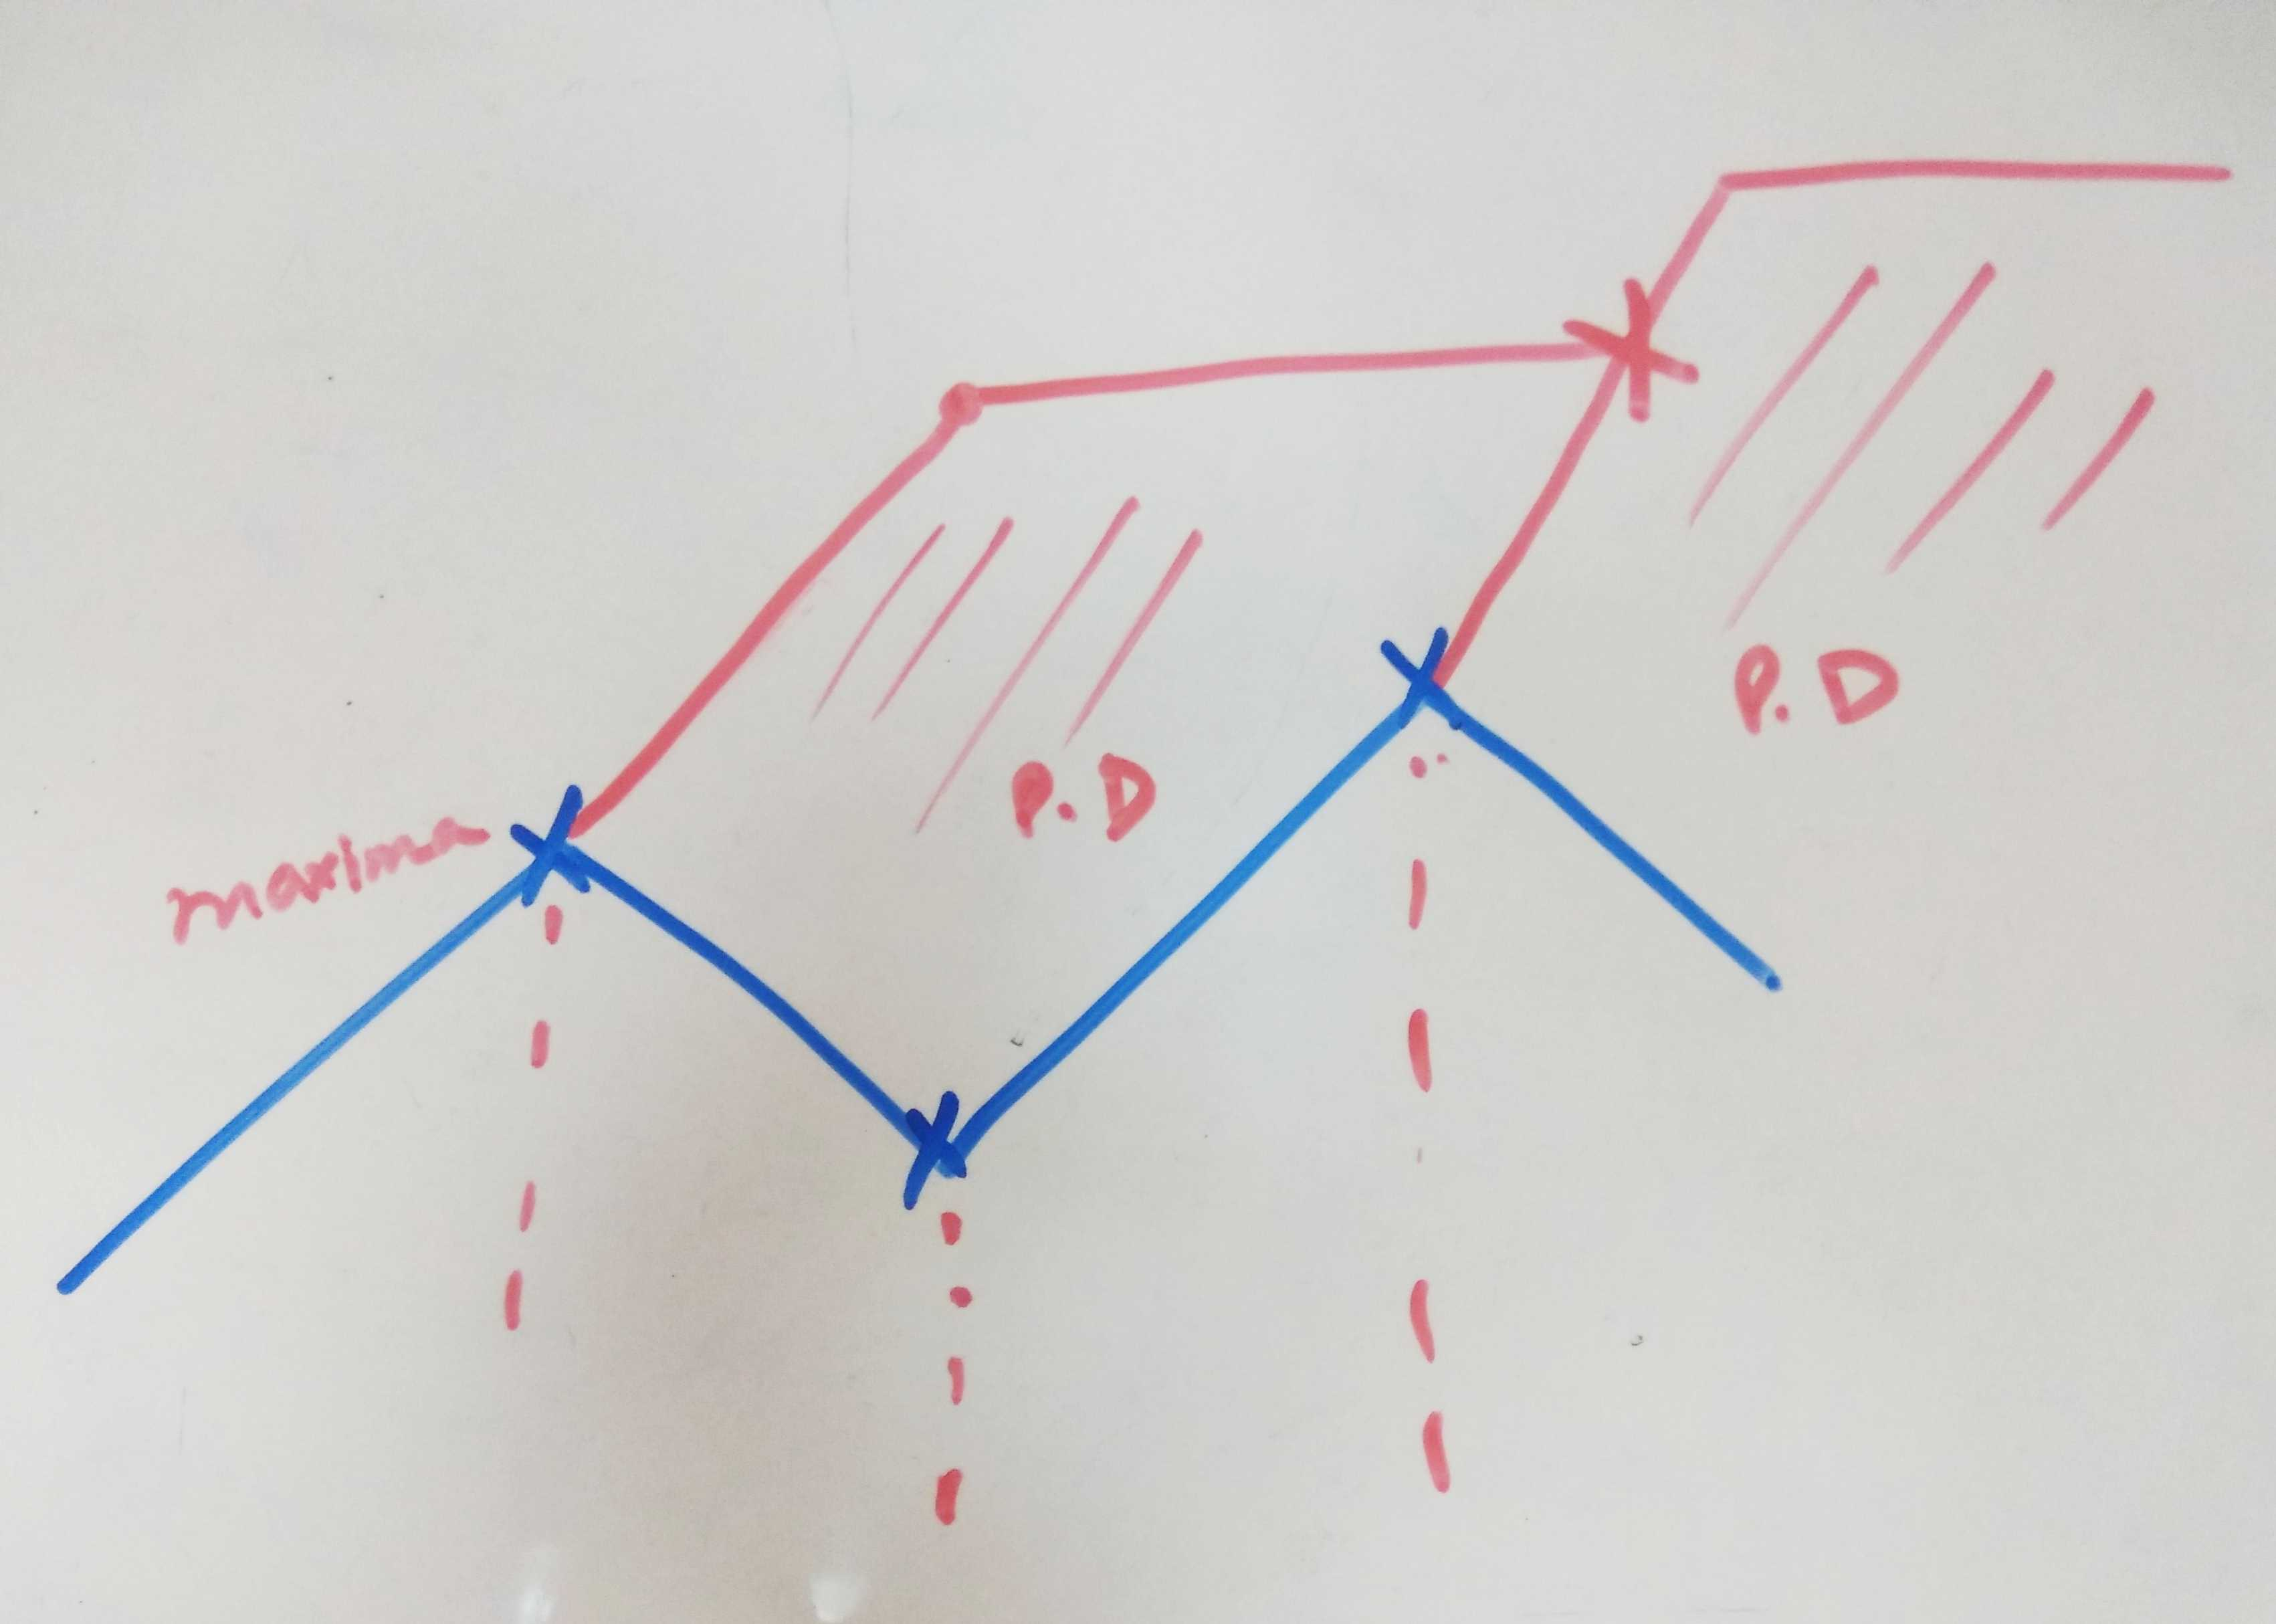

In [24]:
# Maxima appreciation data till next minima/td intersection
Image(filename='../../docs/cannibalisation/images/FIG 5 - maxima appr intersection.jpg')


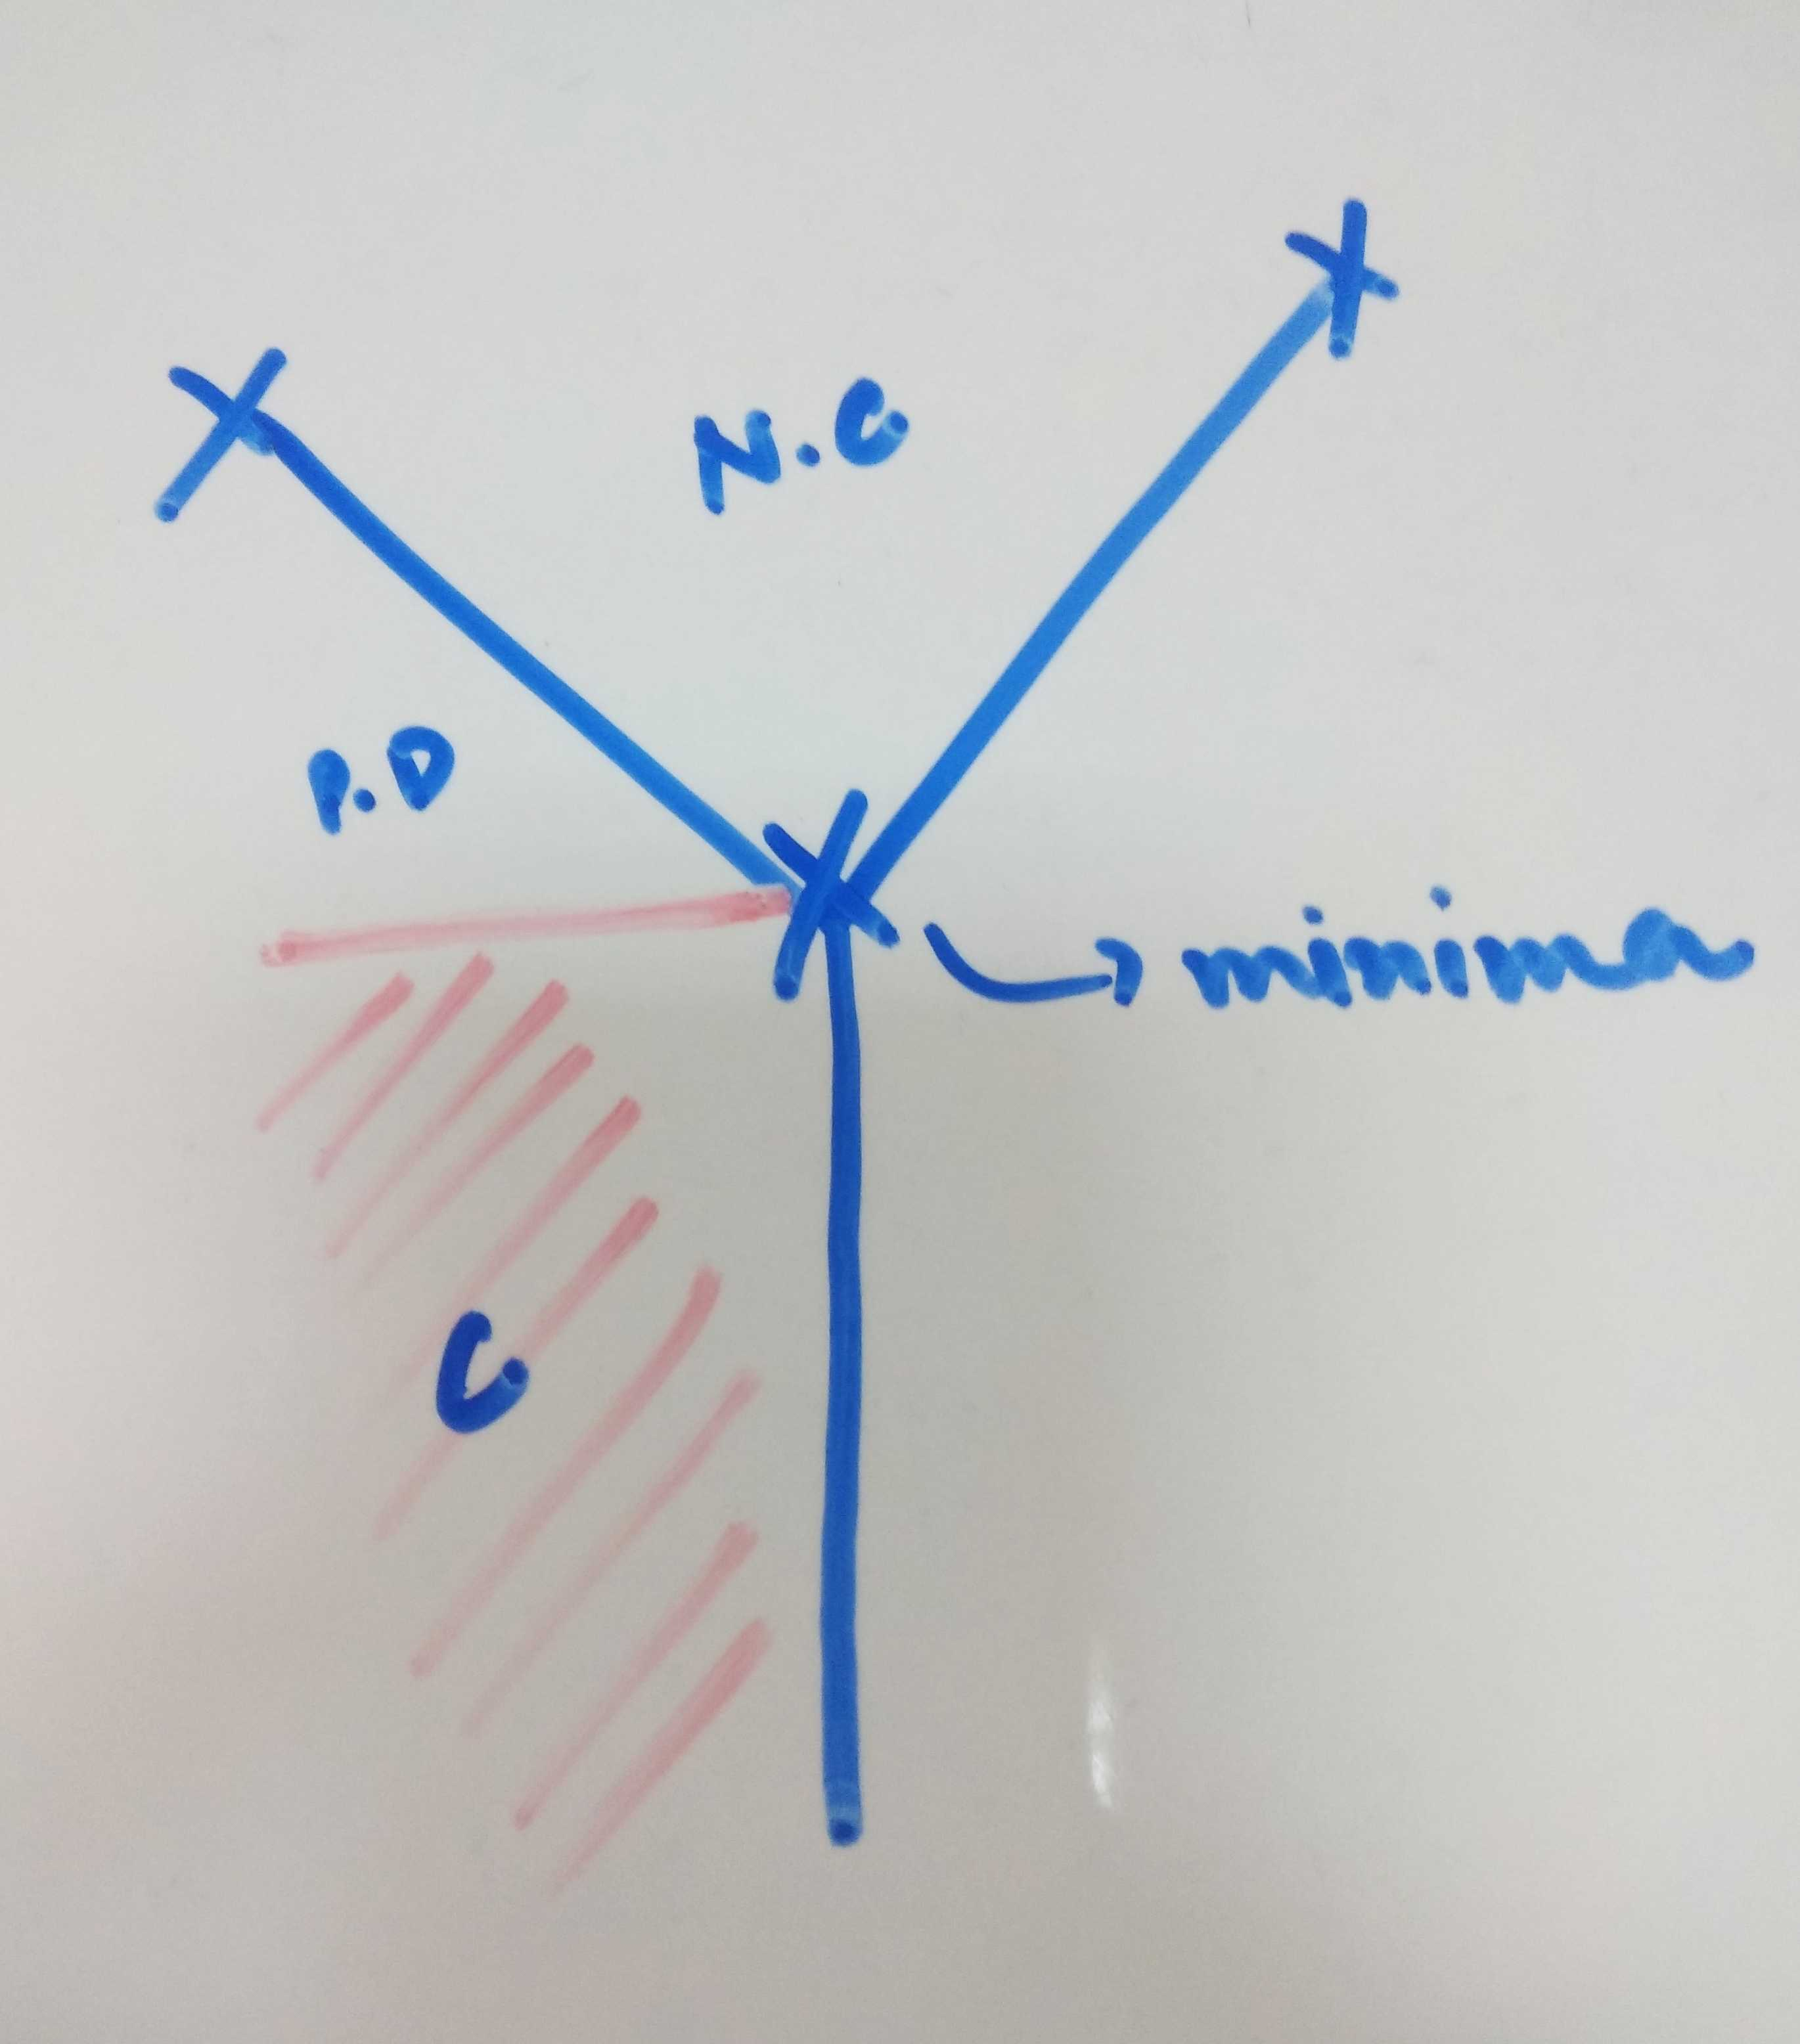

In [26]:
# Minima lower limit depreciation data

Image(filename='../../docs/cannibalisation/images/FIG 6 - minima depr lower limit.jpg')

In [ ]:
def set_nearest_orp(variant_data, city, match_size=2):
    """
    Calculates and sets nearest orp for listings with NULL orp values on basis of
    closest name match in same model
    :param variant_data: list of [td_data, mp_expired, mp_active]
    :param city: city_id
    :param match_size: Number of closest matches to consider
    """
    changed_data = []
    for frame in variant_data:
        null_orp_variants = frame[frame['orp'].isnull()][['model_id', 'variant_id', 'name', 'city_id']]
        if len(null_orp_variants):
            orp_data = sql_result("""select vo.variant_id,  v.model_id, vo.orp, v.name from variant_orps vo 
            join variants v on vo.variant_id=v.id where vo.city_id = {city_id} and v.model_id in ({model_ids}) 
            and vo.orp""".format(city_id=city, model_ids=get_formatted_list(null_orp_variants.model_id.unique())))
            invalid_model_ids = []
            for row in null_orp_variants.itertuples():
                model_orp_data = orp_data[(orp_data.model_id == row.model_id)]
                variant_name = row.name
                cutoff = 0.6
                closest_matches = []
                if len(model_orp_data):
                    while cutoff:
                        closest_matches = difflib.get_close_matches(variant_name, model_orp_data.name.values,
                                                                    match_size, cutoff=cutoff)
                        if not len(closest_matches):
                            cutoff = cutoff - 0.1
                        else:
                            break
                else:
                    invalid_model_ids.append(row.model_id)
                averaged_orp = model_orp_data[model_orp_data.name.isin(closest_matches)][['orp']].mean()
                frame.loc[row.Index, ['orp']] = averaged_orp

            frame = frame[~frame['model_id'].isin(invalid_model_ids)].reset_index(drop=True)
            changed_data.append(frame)
    return changed_data


def add_blanket_to_curve(frame, column, city):
    """
    Enhances curve data using percentage/absolute values
    """
    price_blanket_data = CB_PARAM_DATA.cannibalisation_params['global_parameters']['blanket']
    percentage_blanket = price_blanket_data['percentage'][str(city)]
    absolute_blanket = price_blanket_data['absolute'][str(city)]
    price_blanket = np.maximum(frame[column] * 0.01 * percentage_blanket, [absolute_blanket] * len(frame[column]))
    frame[column] = (frame[column] + price_blanket).round()


def get_city_wise_data(all_data_list, city):
    """
    Filters listings data city wise and applies blanket on td data
    :param all_data_list: [td_data, mp_expired_data, mp_active_data]
    :param city: city_id
    :return: city data list, unique td models list
    """
    city_data = get_column_wise_data(all_data_list, 'city_id', city)
    city_data = set_nearest_orp(city_data, city, match_size=2)
    city_td_active = city_data[0]
    add_blanket_to_curve(city_td_active, 'price', city)
    city_data[0] = city_td_active
    td_models = np.unique(city_td_active['model_id'])
    return city_data, td_models


def get_primary_td_data(city_td_data):
    """
    Selects year-wise highest_price td listing and calculates interpolated price for next year
    """
    primary_data = pd.DataFrame(city_td_data.groupby(['age'], sort=True).max()[['normalised_price', 'id']])
    primary_data.reset_index(level=0, inplace=True)
    return primary_data


def set_normalised_data(overall_mp_data, td_data):
    """
    Sets normalised price for all listings
    'highest_count_variant' : Calculates base orp of variant with max frequency
    :param overall_mp_data: All mp listings data_frame
    :param td_data: TD data_frame
    """
    highest_count_variant = overall_mp_data.variant_id.value_counts().index[0]
    highest_count_variant_orp = overall_mp_data[overall_mp_data.variant_id == highest_count_variant].orp.iloc[0]
    for frame in [overall_mp_data, td_data]:
        frame[['price', 'orp']] = frame[['price', 'orp']].astype('float')
        frame['normalised_price'] = (frame['price'] * highest_count_variant_orp / frame['orp']).round()


def set_super_data_extremes(super_data, extreme_indices, columns_to_replace):
    """
    Set data to max/min for extremes in super curve
    :param super_data: Super data frame
    :param extreme_indices: Indices of extremities
    :param columns_to_replace: Replaceable columns names
    :return:
    """
    for indices, column in zip(extreme_indices, columns_to_replace):
        if len(indices):
            required_data = super_data[super_data.iloc[indices, 1:-2] > 0].iloc[indices, 2:-2]
            super_data.loc[indices, 'max_data'] = required_data.max(axis=1)
            super_data.loc[indices, 'min_data'] = required_data.min(axis=1)
    return super_data.fillna(0)


def get_super_curve(age_data, depr_data, td_data, td_interpolated_data):
    """
    Create super data frame having all the depreciation curves, main Price X Year curve and other segments
    :param age_data: Available MP ages
    :param depr_data: List of all depreciation data (Minima & Maxima)
    :param td_data: TD dataframe
    :param td_interpolated_data: TD interpolated data
    :return: dataframe
    """
    print('td_interpolated_data')
    print('~~~~~~~')
    print(td_interpolated_data)
    all_ages = age_data.tolist() + td_data.age.tolist()
    age_range = np.array(list(range(min(all_ages), max(all_ages) + 1)))
    min_dep_indices = np.where(age_range < td_data.age.min())[0]
    max_dep_indices = np.where(age_range > td_data.age.max())[0]
    extrema_indices = [min_dep_indices, max_dep_indices]
    indices_array = np.concatenate(extrema_indices).ravel()
    extrema_ages = age_range[indices_array]
    extrema_prices = td_interpolated_data[
        td_interpolated_data['age'].isin(extrema_ages)]['normalised_price']
        
    if len(td_data) == 1:
        td_data = td_interpolated_data
    super_curve_data = pd.DataFrame()
    super_curve_data['age'] = np.array(age_range).astype('float')
    super_curve_data = super_curve_data.merge(td_data[['age', 'normalised_price']], on='age', how='left')
    super_curve_data = interpolate_missing_ages_price(super_curve_data, td_data, 'normalised_price')
    super_curve_data.loc[super_curve_data['age'].isin(extrema_ages), ['normalised_price']] = extrema_prices.values.reshape(-1, 1)
    print(super_curve_data.loc[super_curve_data['age'].isin(extrema_ages), ['normalised_price']])
    # Merge super data with all depreciation data with incremental suffixes
    for dep_data_frame, i in zip(depr_data, range(len(depr_data))):
        super_curve_data = super_curve_data.merge(dep_data_frame, on='age', how='left', suffixes=(i, i + 1))
    super_curve_data = super_curve_data.T.drop_duplicates().T.dropna(axis=1, how='all').fillna(0)

    # For ages beyond TD ages, set super curve to respective max and min data of available data segments
    left_indices = np.delete(super_curve_data.index, indices_array)
    td_curve_ages_data = super_curve_data.iloc[left_indices, 1:]
    max_data, min_data = td_curve_ages_data.max(axis=1), td_curve_ages_data[td_curve_ages_data > 0].min(axis=1)
    super_curve_data.loc[left_indices, 'max_data'] = max_data
    super_curve_data.loc[left_indices, 'min_data'] = min_data
    super_curve_data = set_super_data_extremes(super_curve_data, extrema_indices, ['min_data', 'max_data'])
    return super_curve_data


def set_cannibalising_cars(mp_data, ages, minima_dep_list, appr_data):
    """
    Cars in hard cannibalising years and below TD curve along with cars below minimum of the whole curve are
    labelled as cannibalising
    """
    mp_data.loc[(mp_data.age.isin(ages)) &
                (mp_data['mp_price'] <= mp_data['super_price']), ['status']] = 'cannibalising'
    mp_data.loc[mp_data['mp_price'] <= mp_data['min_data'], ['status']] = 'cannibalising'

    for frame in appr_data:
        mp_data['age'] = mp_data['age'].astype('float')
        mp_data = mp_data.merge(frame, on='age', how='left')
        mp_data.loc[(mp_data['mp_price'] <= mp_data.iloc[:, -1]), 'status'] = 'cannibalising'

    for frame in minima_dep_list:
        mp_data = mp_data.merge(frame, on='age', how='left')
        mp_data.loc[(mp_data['mp_price'] < mp_data['super_price']) &
                    (mp_data['mp_price'] > mp_data.iloc[:, -1]), 'status'] = ''

    total_segment_size = len(appr_data) + len(minima_dep_list)
    if total_segment_size:
        mp_data = mp_data.iloc[:, :-total_segment_size]
    return mp_data


def set_push_down_cars(mp_data):
    """
    Cars above TD curve and below maxima's dep segments, cars below TD and not in hard cannibalising age region are
    labelled as push_down
    """
    mp_data.loc[(mp_data['mp_price'] > mp_data['super_price']) &
                (mp_data['mp_price'] <= mp_data['max_data']), ['status']] = 'push_down'
    mp_data.loc[(mp_data['mp_price'] < mp_data['super_price']) & (mp_data['status'] == ''), ['status']] = 'push_down'

    return mp_data


def set_non_cannibalising_cars(mp_data):
    """
    Cars in above all curve segments, cars that have extreme properties are labelled as non_cannibalising
    """
    mp_data.loc[mp_data['mp_price'] > mp_data['max_data'], ['status']] = 'non_cannibalising'
    return mp_data


def get_above_segment_count(mp_data, city, level):
    """
    Sets mp cars labelled as 'push_down' to 'cannibalising' if certain number of segments lie above them year-wise
    """
    pd_limit = CB_PARAM_DATA.cannibalisation_params['levels'][level]['push_down_region_limit'][str(city)]
    countable_columns = np.setdiff1d(mp_data.columns, AVOID_COUNT_COLUMNS)
    mp_data['count_of_cars_above'] = mp_data[
        mp_data.loc[:, countable_columns].apply(lambda x: np.where(x >= mp_data['mp_price'], 1, -1),
                                                 axis=0) == 1].nunique(axis=1)
    mp_data.loc[
        (mp_data['status'] == 'push_down') & (mp_data['count_of_cars_above'] >= pd_limit), ['status']] = 'cannibalising'
    return mp_data


def get_mp_labelled_data(mp_data, city, minima_lower_limit, appr_data, cannibalising_years, level):
    """
    Labels city-model wise MP listings with appropriate status
    :param mp_data: All mp data : expired and active
    :param city: City Id
    :param minima_lower_limit: TD curve minima depreciation data_frame
    :param appr_data: TD curve points appreciation data
    :param cannibalising_years: Hard Cannibalising ages (age, age-1, age+1)
    :param level: Name of the level
    :return: Labelled MP data
    """
    add_log("MP DATA LABELLING STARTED")
#     columns_to_update = ['id', 'status', 'city_id', 'listing_status', 'days_since_active']
    mp_data['status'] = ''
    mp_data['super_price'] = mp_data[['super_price', 'max_data']].bfill(axis=1)['super_price']

    mp_data = set_cannibalising_cars(mp_data, cannibalising_years, minima_lower_limit, appr_data)
    mp_data = set_push_down_cars(mp_data)
    mp_data = set_non_cannibalising_cars(mp_data)
    mp_data = get_above_segment_count(mp_data, city, level)
    model_mp_listings = mp_data
#     .loc[:, columns_to_update]
    model_mp_listings.rename(columns={'id': 'listing_id', 'status': 'current_status'}, inplace=True)
    add_log("MP DATA LABELLING COMPLETED")
    return model_mp_listings


def get_high_age_point(interpolated_data, rel_prices, abs_prices):
    ages = []
    for price, def_price in zip(rel_prices, abs_prices):
        price_line = interpolated_data.copy()
        price_line['normalised_price'] = price
        intersection_point = get_intersection_points(interpolated_data, price_line)
        if not intersection_point:
            ages.append(def_price)
        else:
            ages.append(intersection_point[0][0])
    return ages


def get_cannibalising_years(td_data, city, td_interpolated_data, level):
    interpolated_data = td_interpolated_data
    age_limits = CB_PARAM_DATA.cannibalisation_params['levels'][level]['age_limit']
    absolute_limits = age_limits["absolute"][str(city)]
    relative_age_limit = age_limits["relative"][str(city)]
    low_abs_limit, high_abs_limit = absolute_limits
    td_prices = td_data.normalised_price
    td_ages = td_data.age
    abs_high = td_ages + high_abs_limit
    abs_low = td_ages - low_abs_limit

    rel_max_price = td_prices * (1 + relative_age_limit * 0.01)
    rel_min_price = td_prices * (1 - relative_age_limit * 0.01)
    rel_high_ages = np.ceil(get_high_age_point(interpolated_data, rel_max_price, abs_high))
    rel_low_ages = np.floor(get_high_age_point(interpolated_data, rel_min_price, abs_low))

    ages_df = pd.DataFrame()
    ages_df['td_ages'] = td_ages
    ages_df['abs_high'] = abs_high
    ages_df['abs_low'] = abs_low
    ages_df['high_ages'] = rel_high_ages.astype('int')
    ages_df['low_ages'] = rel_low_ages.astype('int')

    ages_before_td = ages_df.loc[ages_df.high_ages <= ages_df.td_ages].index
    ages_df.loc[ages_before_td, 'high_ages'] = ages_df.loc[ages_before_td, 'abs_high']
    ages_df['high_ages'] = ages_df[['high_ages', 'abs_high']].min(axis=1)
    ages_after_td = ages_df.loc[ages_df.low_ages >= ages_df.td_ages].index
    ages_df.loc[ages_after_td, 'low_ages'] = ages_df.loc[ages_after_td, 'abs_low']
    ages_df['low_ages'] = ages_df[['low_ages', 'abs_low']].max(axis=1)
    ages_df['range'] = [list(range(i, j + 1)) for i, j in ages_df[['low_ages', 'high_ages']].values]

    years = np.unique(ages_df['range'].sum())
    return years, ages_df['high_ages']


def get_mp_status_data(td_active, all_mp_data, depreciation_factors, city, level):
    """
    Retrieves depreciation data, creates super data frame and sets status labels for mp cars
    :param td_active: Model wise all td data
    :param all_mp_data: All mp data
    :param depreciation_factors: City wise depreciation data
    :param city: City Id
    :param level: Name of the level
    :return: Labelled MP data
    """

    primary_td_data = get_primary_td_data(td_active)
    DEPRECIATION_DATA.set_cluster_helper_data(primary_td_data, depreciation_factors, city, level)
    td_interpolated_data = DEPRECIATION_DATA.get_td_interpolated_data()
    curve_columns = ['age', 'normalised_price']
    cannibalising_years, td_max_ages = get_cannibalising_years(primary_td_data[curve_columns], city,
                                                               td_interpolated_data, level)
    all_depr_data, minima_lower_dep_data, appr_data = DEPRECIATION_DATA.get_overall_depreciation_data(td_max_ages)
    super_data_frame = get_super_curve(all_mp_data.age, all_depr_data, primary_td_data, td_interpolated_data)
    mp_data = all_mp_data.merge(super_data_frame, on='age', how='left')
    mp_data.rename(columns={'normalised_price_x': 'mp_price', 'normalised_price_y': 'super_price'}, inplace=True)
    mp_labelled_data = get_mp_labelled_data(mp_data, city, minima_lower_dep_data, appr_data, cannibalising_years,
                                            level)
    return mp_labelled_data, primary_td_data, all_depr_data, super_data_frame


def change_listings_status(listings):
    """
    Sets listings status in database and creates logs
    """
    add_log("LISTING STATUS UPDATE STARTED")
    active_pd_indices = listings[(listings['current_status'] == 'push_down') &
                                 (listings['listing_status'] == 'active')].index
    listings = listings.drop(active_pd_indices).reset_index(drop=True)
    status_dict_data = {'cannibalising': 'expired', 'non_cannibalising': 'active', 'push_down': 'active'}
    source_name = 'cron-increase-mp'
    for status, change_status in status_dict_data.items():
        listings_to_update = pd.DataFrame()
        status_listings = listings.loc[listings['current_status'] == status, :]
        listings_to_update['listing_id'] = status_listings.listing_id.tolist()
        if len(listings_to_update):
            listings_to_update['status'], listings_to_update['source'] = [change_status, source_name]
            listings_to_update = get_formatted_columns(listings_to_update, ['status', 'source'])
            listing_status_db_update(listings_to_update, 'listing_id', change_status)
    add_log("LISTING STATUS UPDATE COMPLETED")


def set_push_down_redis(mp_data):
    """
    Sets push down listings city wise in redis
    pd_city_wise_dict = {city_id: list}
    """
    add_log("REDIS SET PUSH DOWN LISTINGS STARTED")
    pd_listings = mp_data.loc[mp_data['current_status'] == 'push_down', ['city_id', 'listing_id']]
    if len(pd_listings):
        pd_city_wise_dict = pd_listings.groupby('city_id')['listing_id'].apply(list).to_dict()
        redis_obj = RedisManager('recommendation')
        redis_obj.set_value('pd_lt_2_set', pickle.dumps(pd_city_wise_dict, protocol=2))
    add_log("REDIS SET PUSH DOWN LISTINGS COMPLETED")


def get_status_mulitplexed_frame(status_list):
    city_ids_list = list(CB_PARAM_DATA.city_id_name_dict.keys())
    mux = pd.MultiIndex.from_product([status_list, city_ids_list])
    frame = pd.DataFrame({'count': 0}, index=mux)
    return frame


def get_grouped_count(mp_data):
    group_columns = ['current_status', 'city_id']
    mp_count_data = mp_data.groupby(group_columns).count().loc[:, ['listing_id']]
    mp_count_data.columns = ['count']

    return mp_count_data


def get_city_count_df(mp_data, status_list):
    """
    Returns status and city wise listings multi-indexed dataframe
    """
    pd_frame = get_status_mulitplexed_frame(['push_down'])
    active_pd_count = mp_status_dataframe[(mp_data['current_status'] == 'push_down') &
                                          (mp_data['listing_status'] == 'expired')]
    active_pd_count = get_grouped_count(active_pd_count)
    pd_frame.update(active_pd_count)
    mp_count_data = get_grouped_count(mp_data)
    city_count_df = get_status_mulitplexed_frame(status_list)
    city_count_df.update(mp_count_data)
    city_count_df.loc['non_cannibalising'] = city_count_df.loc['non_cannibalising'].values + pd_frame.loc[
        'push_down'].values
    return city_count_df


def log_city_count(mp_data):
    """
    Logs city and status wise count of listings in spreadsheet 'Cannibalisation Logs' : 'Logs'
    """
    add_log("SHEET DATA LOGGING STARTED")
    status_list = ['non_cannibalising', 'cannibalising', 'push_down']
    cannibalisation_sheet = config_data['sheet_keys']['cannibalisation']
    sheet_last_row = int(pd.DataFrame(read_sheet(cannibalisation_sheet['sheet_key'], '{log_sheet}!A2:A'.
                                                 format(log_sheet=cannibalisation_sheet['logs']))).iloc[0, 0]) + 1
    cell_range = 'B{last_row}:N{last_row}'.format(last_row=sheet_last_row)
    city_count_df = get_city_count_df(mp_data, status_list)

    final_list = []
    for status in status_list:
        count_list = city_count_df.loc[[status], 'count'].tolist()
        count_list.append(sum(count_list))
        final_list.extend(count_list)
    final_list = [str(CB_PARAM_DATA.today)] + final_list

    write_in_sheet([final_list], cannibalisation_sheet['sheet_key'], '{log_sheet}!{cell_range}'
                   .format(log_sheet=cannibalisation_sheet['logs'], cell_range=cell_range))
    add_log("SHEET DATA LOGGING COMPLETED")


def get_valid_mp_data(mp_data):
    """
    Removes redundant status data from mp dataframe. ex: 'cannibalising' and already 'expired' cars
    """
    invalid_data = mp_data[
        ((mp_data['current_status'] == 'cannibalising') & (mp_data['listing_status'] == 'expired')) |
        ((mp_data['current_status'] == 'non_cannibalising') & (mp_data['listing_status'] == 'active'))].index
    mp_data = mp_data.drop(invalid_data).reset_index(drop=True)
    mp_data = mp_data.drop_duplicates('listing_id')
    return mp_data


def get_mp_listings_data(data, city_id, level, city_depreciation_factors, model_id):
    mp_listings = pd.DataFrame()
    td_active, mp_expired, mp_active = data
    all_mp_data = pd.concat([mp_expired, mp_active], axis=0).reset_index(drop=True)
    if len(all_mp_data):
        if level == 'model':
            level_depreciation_factors = city_depreciation_factors.get(
                str(model_id), city_depreciation_factors['overall'])
        else:
            level_depreciation_factors = city_depreciation_factors.get('overall')

        set_normalised_data(all_mp_data, td_active)
        mp_listings, primary_td_data, all_depr_data, super_data_frame = get_mp_status_data(td_active, all_mp_data,
                                         level_depreciation_factors,
                                         city_id, level)

    return mp_listings, primary_td_data, all_depr_data, super_data_frame


def get_model_data(city_listings_data, td_unique_models, city_id, city_depreciation_factors):
    model_data = pd.DataFrame()
    for model_id in [217]:
        model_listings_data = get_column_wise_data(city_listings_data, 'model_id', model_id)
        model_listings, primary_td_data, all_depr_data, super_data_frame = get_mp_listings_data(model_listings_data, city_id, 'model',
                                              city_depreciation_factors, model_id)
        model_data = pd.concat([model_data, model_listings], axis=0).reset_index(drop=True)

    return model_data, primary_td_data, all_depr_data, super_data_frame


def get_cluster_data(cluster_data, price_cluster, body_cluster):
    price_low, price_high = price_cluster
    for i, data in list(enumerate(cluster_data)):
        price_data = data[(data['orp'] >= price_low) & (data['orp'] <= price_high)]
        body_price_data = price_data.loc[price_data['body_type'].isin(body_cluster)]
        cluster_data[i] = body_price_data

    return cluster_data


def get_price_body_data(city_listings_data, td_unique_models, city_id,
                        price_clusters, body_clusters,
                        city_depreciation_factors):
    price_body_data = pd.DataFrame()
    city_data = [city_listings_data[0]]
    for frame in city_listings_data[1:]:
        frame = frame.loc[~frame['model_id'].isin(td_unique_models)]
        city_data.append(frame)

    for price_cluster in price_clusters:
        for body_cluster in body_clusters:
            data = copy.deepcopy(city_data)
            cluster_data = get_cluster_data(data, price_cluster, body_cluster)
            td_active = cluster_data[0]
            if len(td_active):
                price_body_listings = get_mp_listings_data(cluster_data, city_id, 'price_body',
                                                           city_depreciation_factors, None)
                price_body_data = pd.concat([price_body_data, price_body_listings],
                                            axis=0).reset_index(drop=True)

    return price_body_data


def get_cannibalisation_data(listings_df_list):
    """
    Main function that fetches city and unique TD model wise data and labels them with required status
    ('cannibalising', 'non_cannibalising', 'push_down')
    :return: Labelled MP data
    """
    mp_dataframe = pd.DataFrame()
    price_clusters = [[0, 300000], [300001, 500000], [500001, 700000],[700001, float("inf")]]
    body_clusters = [['Hatchback', 'Liftback'], ['Sedan', 'Targa', 'Coupe', 'Convertible'], ['MPV', 'Wagon'],
                     ['SUV', 'Crossover', 'Pickup']]
    for city_id in [2]:
        add_log("CANNIBALISATION STARTED FOR CITY ID : " + str(city_id))
        city_depreciation_factors = CB_PARAM_DATA.cannibalisation_params[
            'levels']['model']['depreciation_data'][str(city_id)]
        city_listings_data, td_unique_models = get_city_wise_data(listings_df_list, city_id)
#         price_body_mp_frame = get_price_body_data(city_listings_data, td_unique_models, city_id, price_clusters,
#                                                   body_clusters, city_depreciation_factors)
        model_mp_frame,primary_td_data, all_depr_data, super_data_frame = get_model_data(city_listings_data, 
                                                                                         td_unique_models, city_id, 
                                                                                         city_depreciation_factors)
        mp_dataframe = pd.concat([mp_dataframe, model_mp_frame], axis=0).reset_index(drop=True)
        add_log("CANNIBALISATION COMPLETED FOR CITY ID : " + str(city_id))
    mp_dataframe = get_valid_mp_data(mp_dataframe)

    return mp_dataframe, primary_td_data, all_depr_data, super_data_frame


def apply_user_feedback_filter(listings_data):
    feedback_check_data = sql_result(USER_FEEDBACK_FILTER_QUERY)
    merged_df = listings_data.merge(feedback_check_data, on="listing_id", how='inner')
    cs_count = CB_PARAM_DATA.cannibalisation_params['global_parameters']['min_users']['car_sold_unavailable']
    nr_count = CB_PARAM_DATA.cannibalisation_params['global_parameters']['min_users']['seller_not_reachable']
    merged_df = merged_df.loc[(merged_df['cs_count'] >= cs_count) | (merged_df['nr_count'] >= nr_count)]
    listing_ids = merged_df['listing_id'].tolist()
    mask = ((listings_data['current_status'] == 'cannibalising')
            & (~listings_data.listing_id.isin(listing_ids))) & (listings_data['days_since_active'] <= 30)
    listings_data['current_status'][mask] = 'push_down'

    return listings_data

In [ ]:
def plot_data(mp_dataframe, depr_data, super_data, td_plot):
    mp_data_expired = mp_dataframe[mp_dataframe.listing_status == 'expired'].reset_index(drop=True)
    mp_data_active = mp_dataframe[mp_dataframe.listing_status == 'active'].reset_index(drop=True)
    fig = go.Figure()

    # Add mp data traces to the figure
    fig.add_trace(go.Scatter(x = mp_data_expired.age, y =  mp_data_expired.mp_price, text= "MP Expired: " + mp_data_expired.listing_id.astype(str) + ', Count : ' + mp_data_expired.count_of_cars_above.astype(str) + ', Status: ' + mp_data_expired.current_status + ', is_extreme: ' + mp_data_expired.is_extreme.astype(str), name= "MP Data Expired", mode="markers",
                             marker=dict( color='floralwhite', size=6, line=dict( color='darkmagenta', width=2 ), symbol="circle" )
                            ))
    fig.add_trace(go.Scatter(x = mp_data_active.age, y =  mp_data_active.mp_price,  text= "MP Active: " + mp_data_active.listing_id.astype(str) + ', Count : ' + mp_data_active.count_of_cars_above.astype(str)  + ', Status: ' + mp_data_active.current_status  + ', is_extreme: ' + mp_data_active.is_extreme.astype(str), name= "MP Data Active", mode="markers", 
                             marker=dict( color='LightSkyBlue', size=6, line=dict( color='black', width=2 ), symbol="circle" )))
        
    # Add depreciation data traces
    for df in depr_data:
        if 'price_high' not in df.columns:
            fig.add_trace(go.Scatter( x = df.age, y = df.dep_price, name="Minima Depreciation Curve" ))
        else:
            fig.add_trace(go.Scatter( x = df.age, y = df.price_high, name="Maxima Depreciation Curve" ))
        
    # Add TD price, super max and min data
    fig.add_trace(go.Scatter( x = super_data.age, y = super_data.max_data, mode="lines+markers", name="Super max curve", text= "Super max curve ", line=dict( color='grey', width=2 )))
    fig.add_trace(go.Scatter( x = super_data.age, y = super_data.min_data, mode="lines+markers", name="Super min curve", text= "Super min curve ", line=dict( color='darkgreen', width=2 )))
    fig.add_trace(go.Scatter( x = td_plot.age, y = td_plot.normalised_price, mode="lines+markers", name="Price", text= "TD Active : " + td_plot.id.astype(str), marker=dict( color='slateblue')))
    
    
    # Customization of the plot
    fig.update_layout(
        title=go.layout.Title(
            text="Cannibalisation Plot",
            xref="paper",
            x=0
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text="age",
                font=dict(
                    size=18,
                    color="#7f7f7f"
                )
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text="price",
                font=dict(
                    size=18,
                    color="#7f7f7f"
                )
            )
        )
    )
    
    
    return fig

    

In [5]:
if __name__ == '__main__':
    add_log("CANNIBALISATION FUNCTION STARTED")
    # Fetch global class objects
    CB_PARAM_DATA = CbData()
    DEPRECIATION_DATA = DepreciationData()

    # Get auto expire and eligible MP listings status data
    cb_listings_data = CannibalisationListingsData()
    data_list, auto_expired_listings = cb_listings_data.get_listings_data()
    cannibalisation_status_dataframe = get_cannibalisation_data(data_list)
    mp_status_dataframe = apply_user_feedback_filter(cannibalisation_status_dataframe)